# Imports and Files

In [ ]:
import seaborn as sns
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive

# Mount your Drive
drive.mount('/content/drive')

# Files
ratings100k = "/content/drive/MyDrive/Data/ML at Scale/ml-latest-small/ratings.csv"
movies100k  = "/content/drive/MyDrive/Data/ML at Scale/ml-latest-small/movies.csv"

ratings32m = "/content/drive/MyDrive/Data/ML at Scale/ml-32m/ratings.csv"
movies32m  = "/content/drive/MyDrive/Data/ML at Scale/ml-32m/movies.csv"

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Data/ML at Scale"

/content/drive/MyDrive/Data/ML at Scale


In [ ]:
# Load movie metadata for display (optional)
try:
    movies = pd.read_csv(movies32m)
    print(f"Loaded {len(movies)} movies from movies.csv")
except FileNotFoundError:
    print("Warning: movies.csv not found. Displaying without metadata.")
    movies = None

Loaded 87585 movies from movies.csv


# 1. CSR Data Structure with Train/Test Split

In [ ]:
class RatingsCSR:
    """Optimised dual CSR index using 2 arrays per indexing with train/test split."""

    def __init__(self, ratings_file, test_ratio=0.05, seed=42):
        self.ratings_file = ratings_file
        self.test_ratio = test_ratio
        self.seed = seed

        # User CSR: 2 arrays each for train and test
        self.user_pairs_train = None
        self.user_indptr_train = None
        self.user_pairs_test = None
        self.user_indptr_test = None

        # Movie CSR: 2 arrays each for train and test
        self.movie_pairs_train = None
        self.movie_indptr_train = None
        self.movie_pairs_test = None
        self.movie_indptr_test = None

        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Load ratings into dual CSR format with train/test split."""
        print("Pass 1: dimensions and count...")
        max_user = max_movie = total_ratings = 0

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u, m = int(row[0]), int(row[1])
                max_user = max(max_user, u)
                max_movie = max(max_movie, m)
                total_ratings += 1

        self.n_users = max_user
        self.n_movies = max_movie
        print(f"Users: {self.n_users}, Movies: {self.n_movies}, Ratings: {total_ratings}")

        # Pass 2: Randomly assign ratings to train/test and count
        print("Pass 2: splitting into train/test and counting...")
        np.random.seed(self.seed)

        user_counts_train = np.zeros(self.n_users, dtype=np.int32)
        user_counts_test = np.zeros(self.n_users, dtype=np.int32)
        movie_counts_train = np.zeros(self.n_movies, dtype=np.int32)
        movie_counts_test = np.zeros(self.n_movies, dtype=np.int32)

        # Store which ratings go to train vs test
        is_test = []

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u_idx = int(row[0]) - 1
                m_idx = int(row[1]) - 1
                test = np.random.rand() < self.test_ratio
                is_test.append(test)

                if test:
                    user_counts_test[u_idx] += 1
                    movie_counts_test[m_idx] += 1
                else:
                    user_counts_train[u_idx] += 1
                    movie_counts_train[m_idx] += 1

        train_size = np.sum(user_counts_train)
        test_size = np.sum(user_counts_test)
        print(f"Train: {train_size}, Test: {test_size}")

        # Initialize arrays
        dtype = np.dtype([('idx', np.int32), ('rating', np.float32)])

        self.user_pairs_train = np.zeros(train_size, dtype=dtype)
        self.user_indptr_train = np.zeros(self.n_users + 1, dtype=np.int32)
        self.user_pairs_test = np.zeros(test_size, dtype=dtype)
        self.user_indptr_test = np.zeros(self.n_users + 1, dtype=np.int32)

        self.movie_pairs_train = np.zeros(train_size, dtype=dtype)
        self.movie_indptr_train = np.zeros(self.n_movies + 1, dtype=np.int32)
        self.movie_pairs_test = np.zeros(test_size, dtype=dtype)
        self.movie_indptr_test = np.zeros(self.n_movies + 1, dtype=np.int32)

        # Build index pointers
        self.user_indptr_train[1:] = np.cumsum(user_counts_train)
        self.user_indptr_test[1:] = np.cumsum(user_counts_test)
        self.movie_indptr_train[1:] = np.cumsum(movie_counts_train)
        self.movie_indptr_test[1:] = np.cumsum(movie_counts_test)

        # Pass 3: Fill arrays
        print("Pass 3: filling arrays...")
        user_pos_train = self.user_indptr_train[:-1].copy()
        user_pos_test = self.user_indptr_test[:-1].copy()
        movie_pos_train = self.movie_indptr_train[:-1].copy()
        movie_pos_test = self.movie_indptr_test[:-1].copy()

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for i, row in enumerate(reader):
                u_idx = int(row[0]) - 1
                m_idx = int(row[1]) - 1
                r = float(row[2])

                if is_test[i]:
                    # Test set
                    self.user_pairs_test[user_pos_test[u_idx]] = (m_idx, r)
                    user_pos_test[u_idx] += 1
                    self.movie_pairs_test[movie_pos_test[m_idx]] = (u_idx, r)
                    movie_pos_test[m_idx] += 1
                else:
                    # Train set
                    self.user_pairs_train[user_pos_train[u_idx]] = (m_idx, r)
                    user_pos_train[u_idx] += 1
                    self.movie_pairs_train[movie_pos_train[m_idx]] = (u_idx, r)
                    movie_pos_train[m_idx] += 1

        # Sort all CSRs for efficient access
        print("Pass 4: sorting arrays...")
        self._sort_csr(self.user_pairs_train, self.user_indptr_train, self.n_users)
        self._sort_csr(self.user_pairs_test, self.user_indptr_test, self.n_users)
        self._sort_csr(self.movie_pairs_train, self.movie_indptr_train, self.n_movies)
        self._sort_csr(self.movie_pairs_test, self.movie_indptr_test, self.n_movies)

        print("Done!")
        return self

    def _sort_csr(self, pairs, indptr, n):
        """Sort CSR pairs by index for efficient access."""
        for i in range(n):
            start, end = indptr[i], indptr[i+1]
            if end - start > 1:
                order = np.argsort(pairs[start:end]['idx'], kind='stable')
                pairs[start:end] = pairs[start:end][order]

    def get_user_ratings_train(self, user_idx):
        """Get training ratings for a user (0-indexed).
        Returns: numpy structured array with 'idx' and 'rating' fields
        """
        start, end = self.user_indptr_train[user_idx], self.user_indptr_train[user_idx + 1]
        return self.user_pairs_train[start:end]

    def get_user_ratings_test(self, user_idx):
        """Get test ratings for a user (0-indexed).
        Returns: numpy structured array with 'idx' and 'rating' fields
        """
        start, end = self.user_indptr_test[user_idx], self.user_indptr_test[user_idx + 1]
        return self.user_pairs_test[start:end]

    def get_movie_ratings_train(self, movie_idx):
        """Get training ratings for a movie (0-indexed).
        Returns: numpy structured array with 'idx' and 'rating' fields
        """
        start, end = self.movie_indptr_train[movie_idx], self.movie_indptr_train[movie_idx + 1]
        return self.movie_pairs_train[start:end]

    def get_movie_ratings_test(self, movie_idx):
        """Get test ratings for a movie (0-indexed).
        Returns: numpy structured array with 'idx' and 'rating' fields
        """
        start, end = self.movie_indptr_test[movie_idx], self.movie_indptr_test[movie_idx + 1]
        return self.movie_pairs_test[start:end]

    def get_movie_rating_counts(self):
        """Get array of rating counts per movie (for filtering).
        Returns: numpy array of length n_movies
        """
        counts = np.zeros(self.n_movies, dtype=np.int32)
        for i in range(self.n_movies):
            counts[i] = (self.movie_indptr_train[i + 1] - self.movie_indptr_train[i] +
                        self.movie_indptr_test[i + 1] - self.movie_indptr_test[i])
        return counts

# 2. ALS Training Loop

In [ ]:
def train_als_csr(data_csr, K=20, lambd=0.001, gamma=0.001, tau=0.05,
                  num_iters=30, verbose=True):
    """
    Train ALS model using CSR data structure.

    Args:
        data_csr: RatingsCSR object with train/test split
        K: Number of latent dimensions
        lambd: Update weight factor for ratings
        gamma: Regularization for biases
        tau: Regularization for embeddings
        num_iters: Number of ALS iterations
        verbose: Whether to print progress

    Returns:
        Dictionary containing:
            - user_vectors: (M, K) user embeddings
            - item_vectors: (N, K) item embeddings
            - user_biases: (M,) user biases
            - item_biases: (N,) item biases
            - loss_history: List of training losses
            - rmse_train_history: List of training RMSE
            - rmse_test_history: List of test RMSE
    """
    M = data_csr.n_users
    N = data_csr.n_movies

    # Initialize parameters
    user_biases = np.zeros(M, dtype=np.float32)
    item_biases = np.zeros(N, dtype=np.float32)
    user_vectors = (np.random.randn(M, K) * 0.01).astype(np.float32)
    item_vectors = (np.random.randn(N, K) * 0.01).astype(np.float32)

    # History tracking
    loss_history = []
    rmse_train_history = []
    rmse_test_history = []

    # Calculate global mean
    global_mean = np.mean(data_csr.user_pairs_train['rating'])

    # Pre-allocate matrices for efficiency
    A = np.zeros((K, K), dtype=np.float32)
    b = np.zeros(K, dtype=np.float32)
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    # Main ALS loop
    for iter_num in range(num_iters):

        # ===== UPDATE USER PARAMETERS ===== #
        for m in range(M):
            pairs = data_csr.get_user_ratings_train(m)
            n_ratings = len(pairs)

            if n_ratings == 0:
                continue

            # Extract movie indices and ratings efficiently
            movie_indices = pairs['idx']
            ratings = pairs['rating']

            ## Update User Bias ##
            # Residual: rating - item_bias - dot(u_m, v_n)
            residuals = ratings - global_mean - item_biases[movie_indices]- np.sum(
                user_vectors[m, :] * item_vectors[movie_indices, :], axis=1)
            bias_sum = lambd * np.sum(residuals)
            user_biases[m] = bias_sum / (lambd * n_ratings + gamma)

            ## Update User Embedding ##
            # Recompute residuals after bias update
            residuals = (ratings - global_mean - user_biases[m] - item_biases[movie_indices])

            # A = sum(lambda * v_n * v_n^T) + tau * I
            # b = sum(lambda * residual * v_n)
            V_batch = item_vectors[movie_indices, :]  # (n_ratings, K)

            # Vectorized: A = lambda * V^T @ V + reg
            A = lambd * (V_batch.T @ V_batch) + reg_matrix

            # Vectorized: b = lambda * V^T @ residuals
            b = lambd * (V_batch.T @ residuals)

            # Solve: A * u_m = b
            user_vectors[m, :] = np.linalg.solve(A, b)

        # ===== UPDATE ITEM PARAMETERS ===== #
        for n in range(N):
            pairs = data_csr.get_movie_ratings_train(n)
            n_ratings = len(pairs)

            if n_ratings == 0:
                continue

            # Extract user indices and ratings efficiently
            user_indices = pairs['idx']
            ratings = pairs['rating']

            ## Update Item Bias ##
            residuals = ratings - global_mean - user_biases[user_indices] - np.sum(
                user_vectors[user_indices, :] * item_vectors[n, :], axis=1)
            bias_sum = lambd * np.sum(residuals)
            item_biases[n] = bias_sum / (lambd * n_ratings + gamma)

            ## Update Item Embedding ##
            residuals = (ratings - global_mean - user_biases[user_indices] - item_biases[n])

            U_batch = user_vectors[user_indices, :]  # (n_ratings, K)

            # Vectorized: A = lambd * U^T @ U + reg
            A = lambd * (U_batch.T @ U_batch) + reg_matrix

            # Vectorized: b = lambd * U^T @ residuals
            b = lambd * (U_batch.T @ residuals)

            # Solve: A * v_n = b
            item_vectors[n, :] = np.linalg.solve(A, b)

        # ===== COMPUTE METRICS ===== #
        train_loss, train_rmse = compute_metrics_csr(
            data_csr, user_vectors, item_vectors, user_biases, item_biases, global_mean, train=True
        )
        test_loss, test_rmse = compute_metrics_csr(
            data_csr, user_vectors, item_vectors, user_biases, item_biases, global_mean, train=False
        )

        loss_history.append(train_loss)
        rmse_train_history.append(train_rmse)
        rmse_test_history.append(test_rmse)

        if verbose:
            print(f"Iteration {iter_num+1}/{num_iters}: "
                  f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}, "
                  f"Loss = {train_loss:.2f}")

    return {
        'user_vectors': user_vectors,
        'item_vectors': item_vectors,
        'user_biases': user_biases,
        'item_biases': item_biases,
        'loss_history': loss_history,
        'rmse_train_history': rmse_train_history,
        'rmse_test_history': rmse_test_history
    }


def compute_metrics_csr(data_csr, user_vectors, item_vectors,
                        user_biases, item_biases, global_mean, train=True):
    """
    Compute loss and RMSE on train or test set.

    Args:
        data_csr: RatingsCSR object
        user_vectors, item_vectors, user_biases, item_biases: Model parameters
        global_mean: average rating/score
        train: If True, use train set; else use test set

    Returns:
        loss: Sum of squared errors
        rmse: Root mean squared error
    """
    M = data_csr.n_users
    squared_error = 0.0
    count = 0

    for m in range(M):
        if train:
            pairs = data_csr.get_user_ratings_train(m)
        else:
            pairs = data_csr.get_user_ratings_test(m)

        if len(pairs) == 0:
            continue

        indices = pairs['idx']
        ratings = pairs['rating']

        # Vectorized prediction: mu + b_u + b_i + u.v
        # Note: user_biases[m] is scalar, item_biases[indices] is vector
        dots = np.sum(user_vectors[m] * item_vectors[indices], axis=1)

        predictions = global_mean + user_biases[m] + item_biases[indices] + dots

        squared_error += np.sum((ratings - predictions) ** 2)
        count += len(pairs)

    rmse = np.sqrt(squared_error / count) if count > 0 else 0.0
    return squared_error, rmse


def plot_training_results(results):
    """Plot training history."""
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results['loss_history'], marker='o')
    plt.title("Loss over iterations (Sum of Squared Errors)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(results['rmse_train_history'], marker='o', color='orange', label='Train')
    plt.plot(results['rmse_test_history'], marker='o', color='green', label='Test')
    plt.title("RMSE over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['rmse_test_history'], marker='o', color='green')
    plt.title("Test RMSE over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")

    plt.tight_layout()
    plt.show()

# 3. Dummy User Recommendations + Polarising Movies

In [ ]:
def create_dummy_user_and_recommend(dummy_ratings_ids, user_vectors, item_vectors,
                                     user_biases, item_biases, global_mean, data_csr,
                                     lambd=0.001, tau=0.05, gamma=0.001,
                                     top_k=10, min_ratings=100, bias_weight=0.05):
    """
    Create a dummy user with given ratings and generate recommendations.

    Args:
        dummy_ratings_ids: List of (movie_idx, rating) tuples (0-indexed)
        user_vectors: Trained user embeddings (M, K)
        item_vectors: Trained item embeddings (N, K)
        user_biases: Trained user biases (M,)
        item_biases: Trained item biases (N,)
        data_csr: RatingsCSR object
        lambd: Update weight factor
        tau: Regularization for embeddings
        gamma: Regularization for biases
        top_k: Number of recommendations to return
        min_ratings: Minimum number of ratings a movie must have
        bias_weight: How much to weight the item bias (0.05 = 5%)

    Returns:
        top_movie_indices: List of top K recommended movie indices (0-indexed)
        top_scores: List of corresponding scores
        dummy_user_vector: The computed dummy user embedding
        dummy_user_bias: The computed dummy user bias
    """
    K = user_vectors.shape[1]
    n_ratings = len(dummy_ratings_ids)

    if n_ratings == 0:
        raise ValueError("No valid movie ratings provided")

    print(f"Creating dummy user with {n_ratings} ratings...")

    # Extract movie indices and ratings
    movie_indices = np.array([idx for idx, _ in dummy_ratings_ids], dtype=np.int32)
    ratings = np.array([r for _, r in dummy_ratings_ids], dtype=np.float32)

    # STEP 1: Compute Dummy User Bias #
    residuals = ratings - global_mean - item_biases[movie_indices]
    bias_sum = lambd * np.sum(residuals)
    dummy_user_bias = bias_sum / (lambd * n_ratings + gamma)

    # STEP 2: Compute Dummy User Embedding #
    residuals = ratings - global_mean - dummy_user_bias - item_biases[movie_indices]
    V_batch = item_vectors[movie_indices, :]  # (n_ratings, K)

    # A = lambd * V^T @ V + tau * I
    A = lambd * (V_batch.T @ V_batch) + tau * np.eye(K, dtype=np.float32)

    # b = lambd * V^T @ residuals
    b = lambd * (V_batch.T @ residuals)

    # Solve: A * dummy_user_vector = b
    dummy_user_vector = np.linalg.solve(A, b)

    print(f"Dummy user bias: {dummy_user_bias:.4f}")
    print(f"Dummy user embedding norm: {np.linalg.norm(dummy_user_vector):.4f}")

    # STEP 3: Score All Movies #
    print("\nScoring all movies...")
    N = len(item_biases)

    # Fully vectorized scoring
    scores = (global_mean + item_vectors @ dummy_user_vector +  # Personalization: (N,K) @ (K,) = (N,)
              bias_weight * item_biases)                        # Popularity (downweighted)

    # STEP 4: Filter and Rank #
    print(f"Filtering movies with < {min_ratings} ratings...")

    # Get rating counts per movie
    movie_rating_counts = data_csr.get_movie_rating_counts()

    # Mask out movies with too few ratings
    valid_mask = movie_rating_counts >= min_ratings
    scores[~valid_mask] = -np.inf

    # Also mask out movies the dummy user already rated
    scores[movie_indices] = -np.inf

    # Get top K recommendations
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]

    return top_indices, top_scores, dummy_user_vector, dummy_user_bias


def display_recommendations(top_movie_indices, top_scores, movies_df=None):
    """
    Display recommendations in a nice format.

    Args:
        top_movie_indices: List of recommended movie indices (0-indexed)
        top_scores: List of corresponding scores
        movies_df: Optional pandas DataFrame with columns ['movieId', 'title', 'genres']
    """
    print("TOP RECOMMENDATIONS")

    for i, (movie_idx, score) in enumerate(zip(top_movie_indices, top_scores), 1):
        # Note: movie_idx is 0-indexed, but movieId in CSV is 1-indexed
        # So we need to add 1 when looking up in the CSV
        movie_id = movie_idx + 1

        print(f"\n{i}. Movie Index: {movie_idx} (ID: {movie_id}) | Score: {score:.4f}")

        if movies_df is not None:
            # Look up movie details
            movie_info = movies_df[movies_df['movieId'] == movie_id]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
                genres = movie_info['genres'].values[0]
                print(f"   Title: {title}")
                print(f"   Genres: {genres}")
            else:
                print(f"   (Movie details not found in CSV)")


def get_polarizing_movies(item_vectors, item_biases, data_csr,
                          top_k=20, min_ratings=100):
    """
    Find the most polarizing movies (those with unusually long trait vectors).

    Args:
        item_vectors: Trained item embeddings (N, K)
        item_biases: Trained item biases (N,)
        data_csr: RatingsCSR object
        top_k: Number of movies to return
        min_ratings: Minimum number of ratings a movie must have

    Returns:
        polarizing_indices: Indices of most polarizing movies
        vector_norms: Norms of their trait vectors
    """
    # Compute L2 norm of each item vector
    vector_norms = np.linalg.norm(item_vectors, axis=1)

    # Filter by minimum ratings
    movie_rating_counts = data_csr.get_movie_rating_counts()
    valid_mask = movie_rating_counts >= min_ratings

    # Mask invalid movies
    vector_norms_filtered = vector_norms.copy()
    vector_norms_filtered[~valid_mask] = -np.inf

    # Get top K most polarizing
    polarizing_indices = np.argsort(vector_norms_filtered)[::-1][:top_k]

    return polarizing_indices, vector_norms[polarizing_indices]


def display_polarizing_movies(polarizing_indices, vector_norms, movies_df=None):
    """Display most polarizing movies."""
    print("MOST POLARIZING MOVIES")

    for i, (movie_idx, norm) in enumerate(zip(polarizing_indices, vector_norms), 1):
        movie_id = movie_idx + 1
        print(f"\n{i}. Movie Index: {movie_idx} (ID: {movie_id}) | Vector Norm: {norm:.4f}")

        if movies_df is not None:
            movie_info = movies_df[movies_df['movieId'] == movie_id]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
                genres = movie_info['genres'].values[0]
                print(f"   Title: {title}")
                print(f"   Genres: {genres}")

# 4.1 Training on 100k Dataset

## Load Data and Split

In [ ]:
# @title
print("Loading data...")
data100k = RatingsCSR(
    ratings_file=ratings100k,
    test_ratio=0.1,
    seed=42
)

data100k.load()

print(f"\nDataset info:")
print(f"  Users: {data100k.n_users}")
print(f"  Movies: {data100k.n_movies}")

Loading data...
Pass 1: dimensions and count...
Users: 610, Movies: 193609, Ratings: 100836
Pass 2: splitting into train/test and counting...
Train: 90720, Test: 10116
Pass 3: filling arrays...
Pass 4: sorting arrays...
Done!

Dataset info:
  Users: 610
  Movies: 193609


## ALS Training with CSR

Iteration 1/30: Train RMSE = 0.8086, Test RMSE = 0.8812, Loss = 59310.57
Iteration 2/30: Train RMSE = 0.7937, Test RMSE = 0.8696, Loss = 57147.52
Iteration 3/30: Train RMSE = 0.7925, Test RMSE = 0.8689, Loss = 56972.81
Iteration 4/30: Train RMSE = 0.7923, Test RMSE = 0.8687, Loss = 56943.29
Iteration 5/30: Train RMSE = 0.7922, Test RMSE = 0.8686, Loss = 56933.64
Iteration 6/30: Train RMSE = 0.7922, Test RMSE = 0.8685, Loss = 56928.40
Iteration 7/30: Train RMSE = 0.7921, Test RMSE = 0.8684, Loss = 56924.46
Iteration 8/30: Train RMSE = 0.7921, Test RMSE = 0.8683, Loss = 56921.29
Iteration 9/30: Train RMSE = 0.7921, Test RMSE = 0.8683, Loss = 56918.57
Iteration 10/30: Train RMSE = 0.7921, Test RMSE = 0.8682, Loss = 56916.25
Iteration 11/30: Train RMSE = 0.7921, Test RMSE = 0.8682, Loss = 56914.19
Iteration 12/30: Train RMSE = 0.7920, Test RMSE = 0.8681, Loss = 56912.40
Iteration 13/30: Train RMSE = 0.7920, Test RMSE = 0.8681, Loss = 56910.84
Iteration 14/30: Train RMSE = 0.7920, Test RMSE

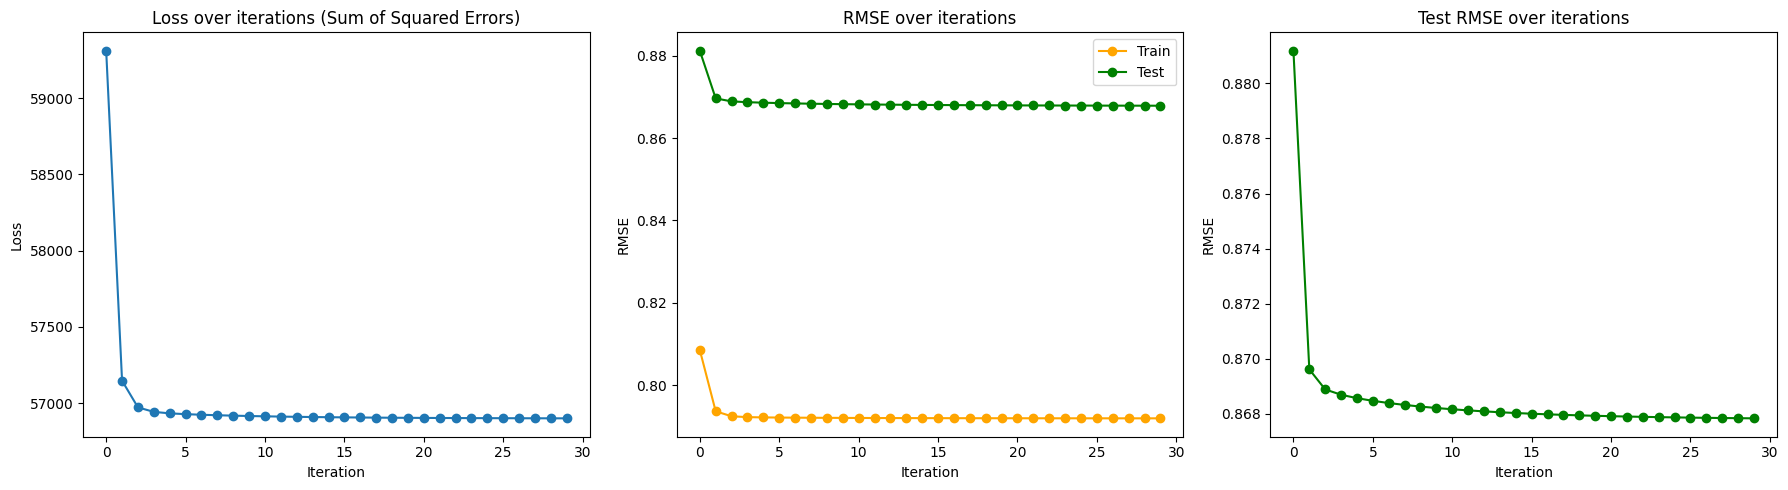

In [ ]:
# @title
results = train_als_csr(
    data_csr=data100k, # CSR structure split data
    K=20,              # Latent dimensions
    lambd=0.001,       # Rating weight
    gamma=0.001,       # Bias regularization
    tau=0.05,          # Embedding regularization
    num_iters=30,      # Number of iterations
    verbose=True       # Tracking
)

# Extract trained parameters
user_vectors = results['user_vectors']
item_vectors = results['item_vectors']
user_biases = results['user_biases']
item_biases = results['item_biases']

print(f"\nFinal Model Parameters:")
print(f"  User embeddings shape: {user_vectors.shape}")
print(f"  Item embeddings shape: {item_vectors.shape}")
print(f"  Final Train RMSE: {results['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE: {results['rmse_test_history'][-1]:.4f}")

# Plot results
plot_training_results(results)

## Recommendations

In [ ]:
# @title
# Example: Create a dummy user who liked these movies (use 0-indexed movie indices)
# You can find movie indices by converting from movie IDs (movie_idx = movies_id - 1)
dummy_ratings = [
    (100, 5.0),   # Loved movie at index 100
    (200, 4.5),   # Really liked movie at index 200
    (300, 4.0),   # Liked movie at index 300
]

top_movie_indices, top_scores, dummy_user_vector, dummy_user_bias = \
    create_dummy_user_and_recommend(
        dummy_ratings_ids=dummy_ratings,
        user_vectors=user_vectors,
        item_vectors=item_vectors,
        user_biases=user_biases,
        item_biases=item_biases,
        global_mean=3.5404269695281982,
        data_csr=data100k,
        lambd=0.001,
        tau=0.05,
        gamma=0.001,
        top_k=10,
        min_ratings=100,
        bias_weight=0.05  # Downweight popularity
    )

# Load movie metadata for display (optional)
try:
    movies_df = pd.read_csv(movies100k)
    print(f"Loaded {len(movies_df)} movies from movies.csv")
except FileNotFoundError:
    print("Warning: movies.csv not found. Displaying without metadata.")
    movies_df = None

# Display recommendations
display_recommendations(top_movie_indices, top_scores, movies_df)

Creating dummy user with 3 ratings...
Dummy user bias: 0.6146
Dummy user embedding norm: 0.0000

Scoring all movies...
Filtering movies with < 100 ratings...
Loaded 9742 movies from movies.csv
TOP RECOMMENDATIONS

1. Movie Index: 317 (ID: 318) | Score: 3.5485
   Title: Shawshank Redemption, The (1994)
   Genres: Crime|Drama

2. Movie Index: 1212 (ID: 1213) | Score: 3.5424
   Title: Goodfellas (1990)
   Genres: Crime|Drama

3. Movie Index: 2958 (ID: 2959) | Score: 3.5423
   Title: Fight Club (1999)
   Genres: Action|Crime|Drama|Thriller

4. Movie Index: 48515 (ID: 48516) | Score: 3.5423
   Title: Departed, The (2006)
   Genres: Crime|Drama|Thriller

5. Movie Index: 1207 (ID: 1208) | Score: 3.5418
   Title: Apocalypse Now (1979)
   Genres: Action|Drama|War

6. Movie Index: 49 (ID: 50) | Score: 3.5415
   Title: Usual Suspects, The (1995)
   Genres: Crime|Mystery|Thriller

7. Movie Index: 857 (ID: 858) | Score: 3.5415
   Title: Godfather, The (1972)
   Genres: Crime|Drama

8. Movie Index: 

## Polarising Movies

In [ ]:
# @title
polarizing_indices, vector_norms = get_polarizing_movies(
    item_vectors=item_vectors,
    item_biases=item_biases,
    data_csr=data100k,
    top_k=10,
    min_ratings=100
)

display_polarizing_movies(polarizing_indices, vector_norms, movies_df)

MOST POLARIZING MOVIES

1. Movie Index: 295 (ID: 296) | Vector Norm: 0.0000
   Title: Pulp Fiction (1994)
   Genres: Comedy|Crime|Drama|Thriller

2. Movie Index: 1731 (ID: 1732) | Vector Norm: 0.0000
   Title: Big Lebowski, The (1998)
   Genres: Comedy|Crime

3. Movie Index: 923 (ID: 924) | Vector Norm: 0.0000
   Title: 2001: A Space Odyssey (1968)
   Genres: Adventure|Drama|Sci-Fi

4. Movie Index: 540 (ID: 541) | Vector Norm: 0.0000
   Title: Blade Runner (1982)
   Genres: Action|Sci-Fi|Thriller

5. Movie Index: 2715 (ID: 2716) | Vector Norm: 0.0000
   Title: Ghostbusters (a.k.a. Ghost Busters) (1984)
   Genres: Action|Comedy|Sci-Fi

6. Movie Index: 857 (ID: 858) | Vector Norm: 0.0000
   Title: Godfather, The (1972)
   Genres: Crime|Drama

7. Movie Index: 1213 (ID: 1214) | Vector Norm: 0.0000
   Title: Alien (1979)
   Genres: Horror|Sci-Fi

8. Movie Index: 259 (ID: 260) | Vector Norm: 0.0000
   Title: Star Wars: Episode IV - A New Hope (1977)
   Genres: Action|Adventure|Sci-Fi

9. Mov

# 4.2 Training on 32m Dataset

## Load Data and Split

In [ ]:
# @title
print("Loading data...")
data32m = RatingsCSR(
    ratings_file=ratings32m,
    test_ratio=0.1,
    seed=42
)

data32m.load()

print(f"\nDataset info:")
print(f"  Users: {data32m.n_users}")
print(f"  Movies: {data32m.n_movies}")

Loading data...
Pass 1: dimensions and count...


KeyboardInterrupt: 

## ALS Training with CSR

Iteration 1/30: Train RMSE = 0.8607, Test RMSE = 0.8694, Loss = 21336734.00
Iteration 2/30: Train RMSE = 0.7960, Test RMSE = 0.8200, Loss = 18247382.00
Iteration 3/30: Train RMSE = 0.7373, Test RMSE = 0.7920, Loss = 15656956.00
Iteration 4/30: Train RMSE = 0.7250, Test RMSE = 0.7829, Loss = 15137133.00
Iteration 5/30: Train RMSE = 0.7202, Test RMSE = 0.7787, Loss = 14936550.00
Iteration 6/30: Train RMSE = 0.7177, Test RMSE = 0.7764, Loss = 14833901.00
Iteration 7/30: Train RMSE = 0.7162, Test RMSE = 0.7750, Loss = 14773297.00
Iteration 8/30: Train RMSE = 0.7153, Test RMSE = 0.7741, Loss = 14733818.00
Iteration 9/30: Train RMSE = 0.7146, Test RMSE = 0.7734, Loss = 14706526.00
Iteration 10/30: Train RMSE = 0.7141, Test RMSE = 0.7730, Loss = 14687142.00
Iteration 11/30: Train RMSE = 0.7138, Test RMSE = 0.7726, Loss = 14672701.00
Iteration 12/30: Train RMSE = 0.7135, Test RMSE = 0.7723, Loss = 14661603.00
Iteration 13/30: Train RMSE = 0.7133, Test RMSE = 0.7721, Loss = 14652989.00
Iteratio

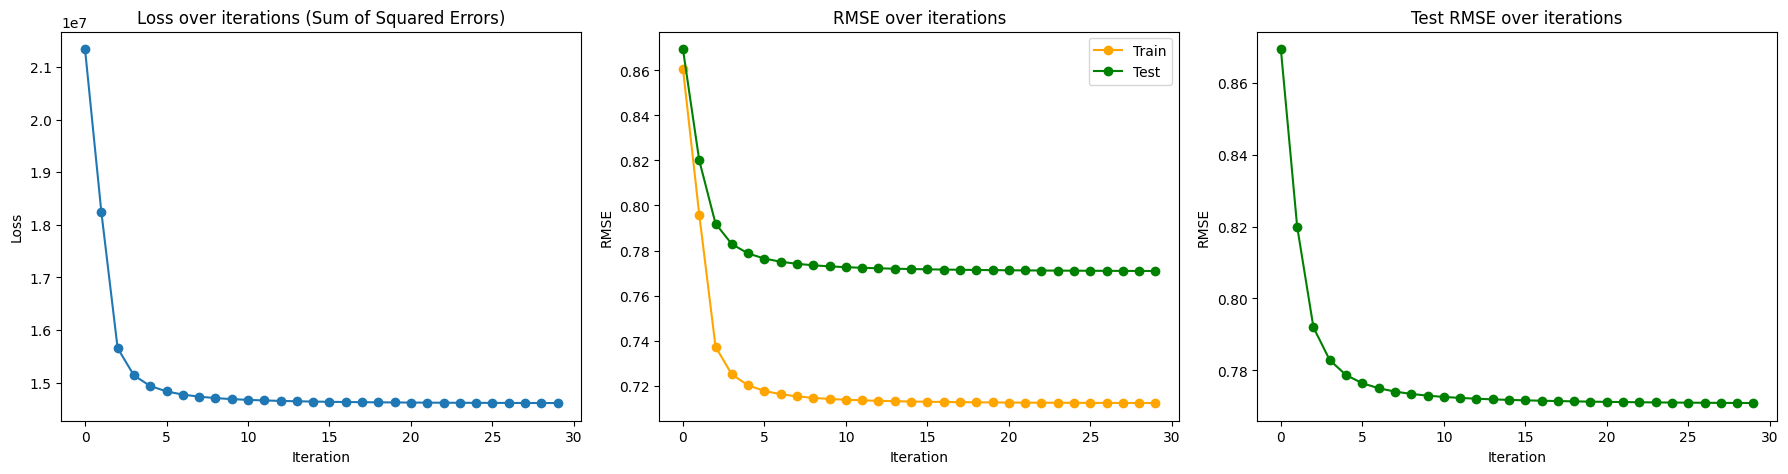

In [ ]:
# @title
results32m = train_als_csr(
    data_csr=data32m, # CSR structure split data
    K=20,              # Latent dimensions
    lambd=0.01,       # Rating weight
    gamma=0.01,       # Bias regularization
    tau=0.1,          # Embedding regularization
    num_iters=30,      # Number of iterations
    verbose=True       # Tracking
)

# Extract trained parameters
user_vectors32m = results32m['user_vectors']
item_vectors32m = results32m['item_vectors']
user_biases32m  = results32m['user_biases']
item_biases32m  = results32m['item_biases']

print(f"\nFinal Model Parameters:")
print(f"  User embeddings shape: {user_vectors32m.shape}")
print(f"  Item embeddings shape: {item_vectors32m.shape}")
print(f"  User Biases shape: {user_biases32m.shape}")
print(f"  Item Biases shape: {item_biases32m.shape}")
print(f"  Final Train RMSE: {results32m['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE: {results32m['rmse_test_history'][-1]:.4f}")

# Plot results
plot_training_results(results32m)

In [ ]:
# Save all parameters
np.savez_compressed(
    '32m_model.npz',
    user_vectors=user_vectors32m,
    item_vectors=item_vectors32m,
    user_biases=user_biases32m,
    item_biases=item_biases32m,
    K=20,
    n_users=data32m.n_users,
    n_movies=data32m.n_movies
)

print("Model saved to 'als_model.npz'")

Model saved to 'als_model.npz'


## Recommendations

In [ ]:
# @title
dummy_ratings = [(0, 5.0)]

top_movie_indices, top_scores, dummy_user_vector, dummy_user_bias = \
    create_dummy_user_and_recommend(
        dummy_ratings_ids=dummy_ratings,
        user_vectors=user_vectors32m,
        item_vectors=item_vectors32m,
        user_biases=user_biases32m,
        item_biases=item_biases32m,
        global_mean=3.5404269695281982,
        data_csr=data32m,
        lambd=0.001,
        tau=0.05,
        gamma=0.001,
        top_k=10,
        min_ratings=100,
        bias_weight=0.05
    )

# Display recommendations
display_recommendations(top_movie_indices, top_scores, movies)

Creating dummy user with 1 ratings...
Dummy user bias: 2.3888
Dummy user embedding norm: 0.1660

Scoring all movies...
Filtering movies with < 100 ratings...
Loaded 87585 movies from movies.csv
TOP RECOMMENDATIONS

1. Movie Index: 3113 (ID: 3114) | Score: 0.9304
   Title: Toy Story 2 (1999)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

2. Movie Index: 78498 (ID: 78499) | Score: 0.8790
   Title: Toy Story 3 (2010)
   Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX

3. Movie Index: 6376 (ID: 6377) | Score: 0.8214
   Title: Finding Nemo (2003)
   Genres: Adventure|Animation|Children|Comedy

4. Movie Index: 4885 (ID: 4886) | Score: 0.8163
   Title: Monsters, Inc. (2001)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

5. Movie Index: 8960 (ID: 8961) | Score: 0.7645
   Title: Incredibles, The (2004)
   Genres: Action|Adventure|Animation|Children|Comedy

6. Movie Index: 363 (ID: 364) | Score: 0.7474
   Title: Lion King, The (1994)
   Genres: Adventure|Animation|Chil

## Polarisation

In [ ]:
# @title
polarizing_indices, vector_norms = get_polarizing_movies(
    item_vectors=item_vectors32m,
    item_biases=item_biases32m,
    data_csr=data32m,
    top_k=10,
    min_ratings=100
)

display_polarizing_movies(polarizing_indices, vector_norms, movies)

MOST POLARIZING MOVIES

1. Movie Index: 4992 (ID: 4993) | Vector Norm: 10.2828
   Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
   Genres: Adventure|Fantasy

2. Movie Index: 7152 (ID: 7153) | Vector Norm: 10.2231
   Title: Lord of the Rings: The Return of the King, The (2003)
   Genres: Action|Adventure|Drama|Fantasy

3. Movie Index: 5951 (ID: 5952) | Vector Norm: 10.0326
   Title: Lord of the Rings: The Two Towers, The (2002)
   Genres: Adventure|Fantasy

4. Movie Index: 259 (ID: 260) | Vector Norm: 9.6563
   Title: Star Wars: Episode IV - A New Hope (1977)
   Genres: Action|Adventure|Sci-Fi

5. Movie Index: 295 (ID: 296) | Vector Norm: 9.6556
   Title: Pulp Fiction (1994)
   Genres: Comedy|Crime|Drama|Thriller

6. Movie Index: 2570 (ID: 2571) | Vector Norm: 9.0402
   Title: Matrix, The (1999)
   Genres: Action|Sci-Fi|Thriller

7. Movie Index: 1195 (ID: 1196) | Vector Norm: 8.9727
   Title: Star Wars: Episode V - The Empire Strikes Back (1980)
   Genres: Action|Adve

# 4.3 Optimised Loading + Train/Test Split (43 seconds)

In [ ]:
# @title
class RatingsCSR2:
    """
    Optimised dual CSR index using lexsort and bincount (NumPy).
    """

    def __init__(self, ratings_file, test_ratio=0.05, seed=42):
        self.ratings_file = ratings_file
        self.test_ratio = test_ratio
        self.seed = seed

        # Data containers
        self.user_pairs_train = None
        self.user_indptr_train = None
        self.user_pairs_test = None
        self.user_indptr_test = None

        self.movie_pairs_train = None
        self.movie_indptr_train = None
        self.movie_pairs_test = None
        self.movie_indptr_test = None

        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Vectorized load function."""
        print("Reading CSV data...")

        # Load data into a numpy array
        # usecols=(0, 1, 2) reads userId, movieId, rating (skips timestamp)
        raw_data = np.loadtxt(self.ratings_file, delimiter=',', skiprows=1, usecols=(0, 1, 2))

        # Separate columns and Zero-index IDs
        # Assuming inputs are floats from loadtxt, cast to appropriate types
        all_users = raw_data[:, 0].astype(np.int32) - 1
        all_movies = raw_data[:, 1].astype(np.int32) - 1
        all_ratings = raw_data[:, 2].astype(np.float32)

        # Determine dimensions
        self.n_users = np.max(all_users) + 1
        self.n_movies = np.max(all_movies) + 1

        print(f"Users: {self.n_users}, Movies: {self.n_movies}, Ratings: {len(all_ratings)}")

        # Train/Test Split
        print("Splitting train/test...")
        np.random.seed(self.seed)

        # Generate mask
        mask_test = np.random.rand(len(all_ratings)) < self.test_ratio
        mask_train = ~mask_test

        # Apply mask
        u_train, m_train, r_train = all_users[mask_train], all_movies[mask_train], all_ratings[mask_train]
        u_test, m_test, r_test    = all_users[mask_test], all_movies[mask_test], all_ratings[mask_test]

        print(f"Train: {len(u_train)}, Test: {len(u_test)}")

        # 4. Build CSR structures
        print("Building CSRs...")

        def build_csr_numpy(primary_ids, secondary_ids, ratings, n_entities):
            """
            Builds CSR arrays using lexsort and bincount.
            primary_ids: The entity we are grouping by (eg. users in User-Indexing)
            secondary_ids: The entity inside the list (eg. movies in User-Indexing)
            """
            # We want to sort by Primary (Primary Key), then Secondary (for order)
            # So we pass (Secondary, Primary)
            sorter = np.lexsort((secondary_ids, primary_ids))

            sorted_secondary = secondary_ids[sorter]
            sorted_ratings = ratings[sorter]
            sorted_primary = primary_ids[sorter]

            # Create structured array for pairs
            pairs = np.zeros(len(ratings), dtype=[('idx', np.int32), ('rating', np.float32)])
            pairs['idx'] = sorted_secondary
            pairs['rating'] = sorted_ratings

            # Calculate Indptr using bincount (gives the number of occurrences of each ID)
            counts = np.bincount(sorted_primary, minlength=n_entities)

            indptr = np.zeros(n_entities + 1, dtype=np.int32)
            indptr[1:] = np.cumsum(counts)

            return pairs, indptr

        # Construct User CSRs (Group by User, order by Movie)
        self.user_pairs_train, self.user_indptr_train = build_csr_numpy(
            u_train, m_train, r_train, self.n_users
        )
        self.user_pairs_test, self.user_indptr_test = build_csr_numpy(
            u_test, m_test, r_test, self.n_users
        )

        # Construct Movie CSRs (Group by Movie, order by User)
        self.movie_pairs_train, self.movie_indptr_train = build_csr_numpy(
            m_train, u_train, r_train, self.n_movies
        )
        self.movie_pairs_test, self.movie_indptr_test = build_csr_numpy(
            m_test, u_test, r_test, self.n_movies
        )

        print("Done!")
        return self

    def get_user_ratings_train(self, user_idx):
        start, end = self.user_indptr_train[user_idx], self.user_indptr_train[user_idx + 1]
        return self.user_pairs_train[start:end]

    def get_user_ratings_test(self, user_idx):
        start, end = self.user_indptr_test[user_idx], self.user_indptr_test[user_idx + 1]
        return self.user_pairs_test[start:end]

    def get_movie_ratings_train(self, movie_idx):
        start, end = self.movie_indptr_train[movie_idx], self.movie_indptr_train[movie_idx + 1]
        return self.movie_pairs_train[start:end]

    def get_movie_ratings_test(self, movie_idx):
        start, end = self.movie_indptr_test[movie_idx], self.movie_indptr_test[movie_idx + 1]
        return self.movie_pairs_test[start:end]

    def get_movie_rating_counts(self):
        # Vectorized count calculation
        train_counts = np.diff(self.movie_indptr_train)
        test_counts = np.diff(self.movie_indptr_test)
        return train_counts + test_counts

In [ ]:
# @title
data32m = RatingsCSR2(
    ratings_file=ratings32m,
    test_ratio=0.1,
    seed=42
)

data32m.load()

print(f"\nDataset info:")
print(f"  Users: {data32m.n_users}")
print(f"  Movies: {data32m.n_movies}")

Reading CSV data...
Users: 200948, Movies: 292757, Ratings: 32000204
Splitting train/test...
Train: 28800054, Test: 3200150
Building CSRs...
Done!

Dataset info:
  Users: 200948
  Movies: 292757


# 4.4 Numba Optimised ALS (50 iterations in 31 minutes)

## User/Item/Wrap Functions

### version 1

In [ ]:
@njit(parallel=True, fastmath=True)
def als_step_user_numba(M, K, user_indptr, user_indices, user_ratings,
                        item_vectors, item_biases, user_vectors, user_biases,
                        lambd, gamma, tau):
    """
    Optimized parallel update for user parameters.
    """
    # Pre-allocate regularization term added to diagonal
    # We add tau to the diagonal of A inside the loop

    for m in prange(M):
        start, end = user_indptr[m], user_indptr[m+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        # 1. Slicing (Numba handles this efficiently as views)
        indices = user_indices[start:end]
        ratings = user_ratings[start:end]

        # 2. Update User Bias
        # Calculate dot products manually or via matrix-vector for speed
        # dot_prod = np.sum(user_vector * item_vectors, axis=1)

        # We need to calculate residuals based on CURRENT user vector
        # residual = r - i_bias - (u . v)

        # Efficient calculation of (V @ u)
        V_batch = item_vectors[indices]
        current_u = user_vectors[m]

        # Calculate prediction part: i_bias + u.v
        # Note: item_biases[indices] + V_batch @ current_u

        pred_rating = item_biases[indices] + V_batch.dot(current_u)
        residuals_bias = ratings - pred_rating

        bias_sum = lambd * np.sum(residuals_bias)

        # Update Bias (Assignment, not accumulation)
        user_biases[m] = bias_sum / (lambd * n_ratings + gamma)

        # 3. Update User Embedding
        # Recompute residuals with the NEW user bias
        # residuals = r - new_u_bias - i_bias
        basic_residuals = ratings - user_biases[m] - item_biases[indices]

        # A = lambda * V.T @ V + tau * I
        # b = lambda * V.T @ residuals

        # Construct A (K x K)
        # V_batch is (n_ratings, K)
        A = lambd * (V_batch.T @ V_batch)

        # Add Regularization (tau * I)
        for k in range(K):
            A[k, k] += tau

        # Construct b (K,)
        b = lambd * (V_batch.T @ basic_residuals)

        # Solve linear system
        user_vectors[m] = np.linalg.solve(A, b)


@njit(parallel=True, fastmath=True)
def als_step_item_numba(N, K, movie_indptr, movie_indices, movie_ratings,
                        user_vectors, user_biases, item_vectors, item_biases,
                        lambd, gamma, tau):
    """
    Optimized parallel update for item parameters.
    """
    for n in prange(N):
        start, end = movie_indptr[n], movie_indptr[n+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        indices = movie_indices[start:end]
        ratings = movie_ratings[start:end]

        # 1. Update Item Bias
        U_batch = user_vectors[indices]
        current_v = item_vectors[n]

        pred_rating = user_biases[indices] + U_batch.dot(current_v)
        residuals_bias = ratings - pred_rating

        bias_sum = lambd * np.sum(residuals_bias)
        item_biases[n] = bias_sum / (lambd * n_ratings + gamma)

        # 2. Update Item Embedding
        basic_residuals = ratings - user_biases[indices] - item_biases[n]

        # A = lambda * U.T @ U + tau * I
        A = lambd * (U_batch.T @ U_batch)

        for k in range(K):
            A[k, k] += tau

        # b = lambda * U.T @ residuals
        b = lambd * (U_batch.T @ basic_residuals)

        # Solve
        item_vectors[n] = np.linalg.solve(A, b)


def train_als_csr(data_csr, K=20, lambd=0.001, gamma=0.001, tau=0.05,
                  num_iters=30, verbose=True):
    """
    Wrapper function for Numba-optimized ALS.
    Matches original function signature.
    """
    M = data_csr.n_users
    N = data_csr.n_movies

    # Initialize parameters
    # Ensure float32/float64 consistency for Numba
    user_biases = np.zeros(M, dtype=np.float64)
    item_biases = np.zeros(N, dtype=np.float64)
    user_vectors = (np.random.randn(M, K) * 0.01).astype(np.float64)
    item_vectors = (np.random.randn(N, K) * 0.01).astype(np.float64)

    # Extract raw arrays from CSR object for Numba
    # We assume data_csr.user_pairs_train is a structured array with 'idx' and 'rating'
    u_indptr = data_csr.user_indptr_train
    u_indices = data_csr.user_pairs_train['idx']
    u_ratings = data_csr.user_pairs_train['rating'].astype(np.float64)

    m_indptr = data_csr.movie_indptr_train
    m_indices = data_csr.movie_pairs_train['idx']
    m_ratings = data_csr.movie_pairs_train['rating'].astype(np.float64)

    # History tracking
    loss_history = []
    rmse_train_history = []
    rmse_test_history = []

    if verbose:
        print(f"Starting Numba-optimized ALS training for {num_iters} iterations...")

    start_time = time.time()

    for iter_num in range(num_iters):
        # ===== UPDATE USER PARAMETERS ===== #
        als_step_user_numba(M, K, u_indptr, u_indices, u_ratings,
                            item_vectors, item_biases, user_vectors, user_biases,
                            lambd, gamma, tau)

        # ===== UPDATE ITEM PARAMETERS ===== #
        als_step_item_numba(N, K, m_indptr, m_indices, m_ratings,
                            user_vectors, user_biases, item_vectors, item_biases,
                            lambd, gamma, tau)

        # ===== COMPUTE METRICS ===== #
        # Ensure it accepts the updated vector types
        train_loss, train_rmse = compute_metrics_csr(
            data_csr, user_vectors, item_vectors, user_biases, item_biases, train=True
        )
        _, test_rmse = compute_metrics_csr(
            data_csr, user_vectors, item_vectors, user_biases, item_biases, train=False
        )

        loss_history.append(train_loss)
        rmse_train_history.append(train_rmse)
        rmse_test_history.append(test_rmse)

        if verbose:
            print(f"Iteration {iter_num+1}/{num_iters}: "
                  f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}, "
                  f"Loss = {train_loss:.2f}")

    if verbose:
        print(f"Training complete in {time.time() - start_time:.2f} seconds.")

    return {
        'user_vectors': user_vectors,
        'item_vectors': item_vectors,
        'user_biases': user_biases,
        'item_biases': item_biases,
        'loss_history': loss_history,
        'rmse_train_history': rmse_train_history,
        'rmse_test_history': rmse_test_history
    }

### version 2

In [ ]:
@njit(parallel=True, fastmath=True)
def als_step_user_numba(M, K, user_indptr, user_indices, user_ratings,
                        item_vectors, item_biases, user_vectors, user_biases,
                        lambd, gamma, tau):
    """
    Optimized parallel update for user parameters using Matrix-Vector operations.
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for m in prange(M):
        start, end = user_indptr[m], user_indptr[m+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        # 1. Slice Data
        indices = user_indices[start:end]
        ratings = user_ratings[start:end]

        # OPTIMIZATION: Fetch V matrix for these items ONCE
        # This enables matrix operations for both bias and vector updates
        V_batch = item_vectors[indices]  # Shape: (n_ratings, K)

        # 2. Update User Bias
        # Vectorized prediction: (n_ratings, K) @ (K,) -> (n_ratings,)
        dots = V_batch.dot(user_vectors[m])

        # Residual = Rating - (Item_Bias + User_Vector . Item_Vector)
        # Note: user_bias is not in this residual because we are solving for it
        residuals = ratings - item_biases[indices] - dots

        bias_sum = lambd * np.sum(residuals)

        # Update Bias (In-place assignment)
        user_biases[m] = bias_sum / (lambd * n_ratings + gamma)

        # 3. Update User Embedding
        # Recompute residuals with the NEW user bias
        # This removes the bias part from the target, leaving only the interaction to be explained by vectors
        base_residuals = ratings - user_biases[m] - item_biases[indices]

        # Solve Linear System: (V.T @ V + I*tau) * u = V.T @ residuals

        # A = lambda * V.T @ V + tau * I
        A = lambd * (V_batch.T @ V_batch) + reg_matrix

        # b = lambda * V.T @ residuals
        b = lambd * (V_batch.T @ base_residuals)

        # Solve A * u = b
        user_vectors[m] = np.linalg.solve(A, b)


@njit(parallel=True, fastmath=True)
def als_step_item_numba(N, K, movie_indptr, movie_indices, movie_ratings,
                        user_vectors, user_biases, item_vectors, item_biases,
                        lambd, gamma, tau):
    """
    Optimized parallel update for item parameters using Matrix-Vector operations.
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for n in prange(N):
        start, end = movie_indptr[n], movie_indptr[n+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        indices = movie_indices[start:end]
        ratings = movie_ratings[start:end]

        # OPTIMIZATION: Fetch U matrix for these users ONCE
        U_batch = user_vectors[indices] # Shape: (n_ratings, K)

        # 1. Update Item Bias
        # Vectorized prediction
        dots = U_batch.dot(item_vectors[n])

        residuals = ratings - user_biases[indices] - dots
        bias_sum = lambd * np.sum(residuals)

        # Update Bias
        item_biases[n] = bias_sum / (lambd * n_ratings + gamma)

        # 2. Update Item Embedding
        base_residuals = ratings - user_biases[indices] - item_biases[n]

        # A = lambda * U.T @ U + tau * I
        A = lambd * (U_batch.T @ U_batch) + reg_matrix

        # b = lambda * U.T @ residuals
        b = lambd * (U_batch.T @ base_residuals)

        # Solve
        item_vectors[n] = np.linalg.solve(A, b)


def train_als_csr(data_csr, K=20, lambd=0.001, gamma=0.001, tau=0.05,
                  num_iters=30, verbose=True):
    """
    Wrapper function for Numba-optimized ALS.
    """
    M = data_csr.n_users
    N = data_csr.n_movies

    # Initialize parameters (ensure float32/64 consistency)
    # Using float32 for speed/memory, can switch to float64 for precision
    dtype = np.float32

    user_biases = np.zeros(M, dtype=dtype)
    item_biases = np.zeros(N, dtype=dtype)
    user_vectors = (np.random.randn(M, K) * 0.01).astype(dtype)
    item_vectors = (np.random.randn(N, K) * 0.01).astype(dtype)

    # Extract raw arrays for Numba
    u_ptr = data_csr.user_indptr_train
    u_indices = data_csr.user_pairs_train['idx']
    u_ratings = data_csr.user_pairs_train['rating'].astype(dtype)

    m_ptr = data_csr.movie_indptr_train
    m_indices = data_csr.movie_pairs_train['idx']
    m_ratings = data_csr.movie_pairs_train['rating'].astype(dtype)

    loss_history = []
    rmse_train_history = []
    rmse_test_history = []

    if verbose:
        print(f"Starting vectorized Numba ALS training for {num_iters} iterations...")

    start_time = time.time()

    for iter_num in range(num_iters):
        # ===== UPDATE USER PARAMETERS ===== #
        als_step_user_numba(M, K, u_ptr, u_indices, u_ratings,
                            item_vectors, item_biases, user_vectors, user_biases,
                            lambd, gamma, tau)

        # ===== UPDATE ITEM PARAMETERS ===== #
        als_step_item_numba(N, K, m_ptr, m_indices, m_ratings,
                            user_vectors, user_biases, item_vectors, item_biases,
                            lambd, gamma, tau)

        # ===== COMPUTE METRICS ===== #
        # Note: We re-use your existing compute_metrics_csr function
        # Make sure it accepts the vectors
        if verbose:
            _, train_rmse = compute_metrics_csr(
                data_csr, user_vectors, item_vectors, user_biases, item_biases, train=True
            )
            _, test_rmse = compute_metrics_csr(
                data_csr, user_vectors, item_vectors, user_biases, item_biases, train=False
            )

            rmse_train_history.append(train_rmse)
            rmse_test_history.append(test_rmse)

            # Optional: Calculate loss if needed (expensive)
            # loss_history.append(train_loss)

            print(f"Iteration {iter_num+1}/{num_iters}: "
                  f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

    if verbose:
        print(f"Training complete in {time.time() - start_time:.2f} seconds.")

    return {
        'user_vectors': user_vectors,
        'item_vectors': item_vectors,
        'user_biases': user_biases,
        'item_biases': item_biases,
        'loss_history': loss_history,
        'rmse_train_history': rmse_train_history,
        'rmse_test_history': rmse_test_history
    }

### version 3

In [ ]:
@njit(parallel=True, fastmath=True)
def als_step_user_numba(M, K, user_indptr, user_indices, user_ratings,
                        item_vectors, item_biases, user_vectors, user_biases,
                        lambd, gamma, tau, global_mean):
    """
    Optimized user update with Global Mean.
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for m in prange(M):
        start, end = user_indptr[m], user_indptr[m+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        indices = user_indices[start:end]
        ratings = user_ratings[start:end]

        # Fetch V matrix once
        V_batch = item_vectors[indices]

        # 1. Update User Bias
        # Prediction part: mu + b_i + u.v
        dots = V_batch.dot(user_vectors[m])

        # Residual = Rating - (Global_Mean + Item_Bias + Dot_Product)
        residuals = ratings - global_mean - item_biases[indices] - dots

        bias_sum = lambd * np.sum(residuals)
        user_biases[m] = bias_sum / (lambd * n_ratings + gamma)

        # 2. Update User Embedding
        # Recompute residuals with NEW user bias
        # Target for vector = Rating - (Global_Mean + User_Bias + Item_Bias)
        base_residuals = ratings - global_mean - user_biases[m] - item_biases[indices]

        # Linear System: (V.T @ V + tau*I) * u = V.T @ residuals
        A = lambd * (V_batch.T @ V_batch) + reg_matrix
        b = lambd * (V_batch.T @ base_residuals)

        user_vectors[m] = np.linalg.solve(A, b)


@njit(parallel=True, fastmath=True)
def als_step_item_numba(N, K, movie_indptr, movie_indices, movie_ratings,
                        user_vectors, user_biases, item_vectors, item_biases,
                        lambd, gamma, tau, global_mean):
    """
    Optimized item update with Global Mean.
    """
    reg_matrix = tau * np.eye(K, dtype=np.float32)

    for n in prange(N):
        start, end = movie_indptr[n], movie_indptr[n+1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        indices = movie_indices[start:end]
        ratings = movie_ratings[start:end]

        U_batch = user_vectors[indices]

        # 1. Update Item Bias
        dots = U_batch.dot(item_vectors[n])

        # Residual = Rating - (Global_Mean + User_Bias + Dot_Product)
        residuals = ratings - global_mean - user_biases[indices] - dots

        bias_sum = lambd * np.sum(residuals)
        item_biases[n] = bias_sum / (lambd * n_ratings + gamma)

        # 2. Update Item Embedding
        # Target for vector = Rating - (Global_Mean + User_Bias + Item_Bias)
        base_residuals = ratings - global_mean - user_biases[indices] - item_biases[n]

        A = lambd * (U_batch.T @ U_batch) + reg_matrix
        b = lambd * (U_batch.T @ base_residuals)

        item_vectors[n] = np.linalg.solve(A, b)


def train_als_csr(data_csr, K=20, lambd=0.001, gamma=0.001, tau=0.05,
                  num_iters=30, verbose=True):
    """
    Wrapper for Numba ALS with Global Mean.
    """
    M = data_csr.n_users
    N = data_csr.n_movies

    # 1. Calculate Global Mean efficiently
    # user_pairs_train is a structured array, 'rating' is one of the fields
    global_mean = np.mean(data_csr.user_pairs_train['rating'])
    if verbose:
        print(f"Global Mean Rating: {global_mean:.4f}")

    # Initialize parameters (float32 or float64)
    dtype = np.float32
    user_biases = np.zeros(M, dtype=dtype)
    item_biases = np.zeros(N, dtype=dtype)
    user_vectors = (np.random.randn(M, K) * 0.01).astype(dtype)
    item_vectors = (np.random.randn(N, K) * 0.01).astype(dtype)

    # Extract raw arrays for Numba
    u_ptr = data_csr.user_indptr_train
    u_indices = data_csr.user_pairs_train['idx']
    u_ratings = data_csr.user_pairs_train['rating'].astype(dtype)

    m_ptr = data_csr.movie_indptr_train
    m_indices = data_csr.movie_pairs_train['idx']
    m_ratings = data_csr.movie_pairs_train['rating'].astype(dtype)

    loss_history = []
    rmse_train_history = []
    rmse_test_history = []

    start_time = time.time()

    for iter_num in range(num_iters):
        # User Step
        als_step_user_numba(M, K, u_ptr, u_indices, u_ratings,
                            item_vectors, item_biases, user_vectors, user_biases,
                            lambd, gamma, tau, global_mean)

        # Item Step
        als_step_item_numba(N, K, m_ptr, m_indices, m_ratings,
                            user_vectors, user_biases, item_vectors, item_biases,
                            lambd, gamma, tau, global_mean)

        # Metrics
        if verbose:
            # Pass global_mean to metrics function
            _, train_rmse = compute_metrics_csr(
                data_csr, user_vectors, item_vectors, user_biases, item_biases,
                global_mean, train=True
            )
            _, test_rmse = compute_metrics_csr(
                data_csr, user_vectors, item_vectors, user_biases, item_biases,
                global_mean, train=False
            )

            rmse_train_history.append(train_rmse)
            rmse_test_history.append(test_rmse)

            print(f"Iteration {iter_num+1}/{num_iters}: "
                  f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

    if verbose:
        print(f"Training complete in {time.time() - start_time:.2f} seconds.")

    # Return dictionary now includes global_mean so we can use it for predictions later
    return {
        'user_vectors': user_vectors,
        'item_vectors': item_vectors,
        'user_biases': user_biases,
        'item_biases': item_biases,
        'global_mean': global_mean,
        'loss_history': loss_history,
        'rmse_train_history': rmse_train_history,
        'rmse_test_history': rmse_test_history
    }

## Train on 32m

Global Mean Rating: 3.5404
Iteration 1/50: Train RMSE = 0.8457, Test RMSE = 0.8657
Iteration 2/50: Train RMSE = 0.7259, Test RMSE = 0.8347
Iteration 3/50: Train RMSE = 0.6997, Test RMSE = 0.8080
Iteration 4/50: Train RMSE = 0.6880, Test RMSE = 0.7950
Iteration 5/50: Train RMSE = 0.6816, Test RMSE = 0.7875
Iteration 6/50: Train RMSE = 0.6776, Test RMSE = 0.7828
Iteration 7/50: Train RMSE = 0.6750, Test RMSE = 0.7798
Iteration 8/50: Train RMSE = 0.6733, Test RMSE = 0.7777
Iteration 9/50: Train RMSE = 0.6720, Test RMSE = 0.7762
Iteration 10/50: Train RMSE = 0.6711, Test RMSE = 0.7752
Iteration 11/50: Train RMSE = 0.6704, Test RMSE = 0.7744
Iteration 12/50: Train RMSE = 0.6699, Test RMSE = 0.7737
Iteration 13/50: Train RMSE = 0.6695, Test RMSE = 0.7732
Iteration 14/50: Train RMSE = 0.6691, Test RMSE = 0.7728
Iteration 15/50: Train RMSE = 0.6689, Test RMSE = 0.7725
Iteration 16/50: Train RMSE = 0.6686, Test RMSE = 0.7722
Iteration 17/50: Train RMSE = 0.6684, Test RMSE = 0.7720
Iteration 18/

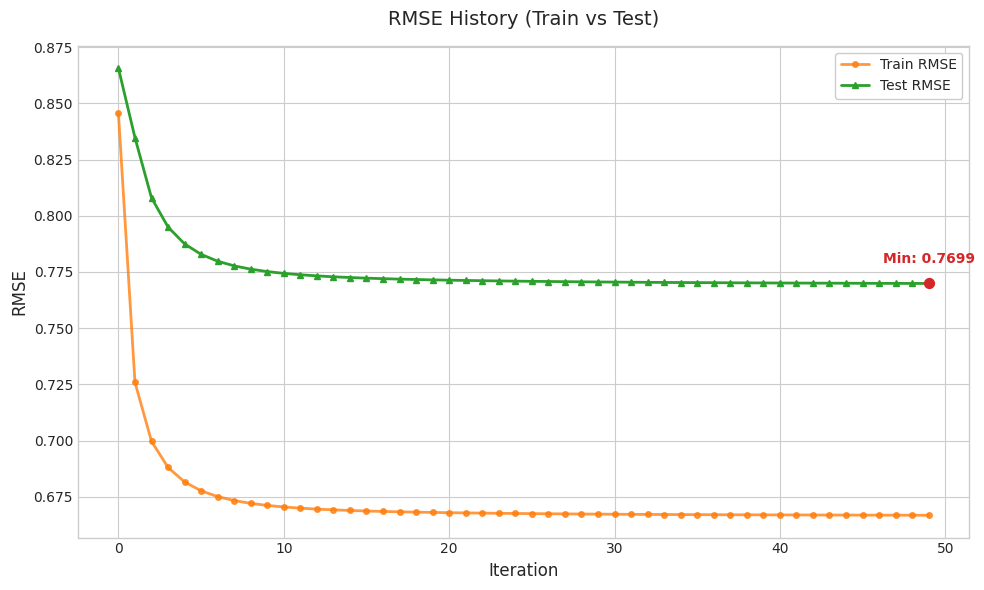

In [ ]:
# @title
results32m = train_als_csr(
    data_csr=data32m, # CSR structure split data
    K=20,             # Latent dimensions
    lambd=0.01,       # Rating weight
    gamma=0.01,       # Bias regularization
    tau=0.1,          # Embedding regularization
    num_iters=50,     # Number of iterations
    verbose=True      # Tracking
)

# Extract trained parameters
user_vectors32m = results32m['user_vectors']
item_vectors32m = results32m['item_vectors']
user_biases32m  = results32m['user_biases']
item_biases32m  = results32m['item_biases']
global_mean32m  = results32m['global_mean']

print(f"\nFinal Model Parameters:")
print(f"  User embeddings shape: {user_vectors32m.shape}")
print(f"  Item embeddings shape: {item_vectors32m.shape}")
print(f"  User Biases shape: {user_biases32m.shape}")
print(f"  Item Biases shape: {item_biases32m.shape}")
print(f"  Final Train RMSE: {results32m['rmse_train_history'][-1]:.4f}")
print(f"  Final Test RMSE: {results32m['rmse_test_history'][-1]:.4f}")

# Plot results
plot_training_results(results32m)

In [ ]:
# Save all parameters
np.savez_compressed(
    '32m_model_k2.npz',
    user_vectors=user_vectors32m,
    item_vectors=item_vectors32m,
    user_biases=user_biases32m,
    item_biases=item_biases32m,
    global_mean=global_mean32m,
    K=20,
    n_users=data32m.n_users,
    n_movies=data32m.n_movies
)

print("Model saved to 'als_model_k2.npz'")

Model saved to 'als_model_k2.npz'


In [ ]:
# @title
dummy_ratings = [(0, 5.0)] # toy story

top_movie_indices, top_scores, dummy_user_vector, dummy_user_bias = \
    create_dummy_user_and_recommend(
        dummy_ratings_ids=dummy_ratings,
        user_vectors=user_vectors32m,
        item_vectors=item_vectors32m,
        user_biases=user_biases32m,
        item_biases=item_biases32m,
        global_mean=global_mean32m,
        data_csr=data32m,
        lambd=0.001,
        tau=0.05,
        gamma=0.001,
        top_k=10,
        min_ratings=100,
        bias_weight=0.05
    )

# Load movie metadata for display
try:
    movies = pd.read_csv(movies32m)
    print(f"Loaded {len(movies)} movies from movies.csv")
except FileNotFoundError:
    print("Warning: movies.csv not found. Displaying without metadata.")
    movies = None

# Display recommendations
display_recommendations(top_movie_indices, top_scores, movies)

Creating dummy user with 1 ratings...
Dummy user bias: 0.6186
Dummy user embedding norm: 0.0430

Scoring all movies...
Filtering movies with < 100 ratings...
Loaded 87585 movies from movies.csv
TOP RECOMMENDATIONS

1. Movie Index: 3113 (ID: 3114) | Score: 3.7845
   Title: Toy Story 2 (1999)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

2. Movie Index: 78498 (ID: 78499) | Score: 3.7741
   Title: Toy Story 3 (2010)
   Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX

3. Movie Index: 6376 (ID: 6377) | Score: 3.7622
   Title: Finding Nemo (2003)
   Genres: Adventure|Animation|Children|Comedy

4. Movie Index: 4885 (ID: 4886) | Score: 3.7606
   Title: Monsters, Inc. (2001)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

5. Movie Index: 8960 (ID: 8961) | Score: 3.7483
   Title: Incredibles, The (2004)
   Genres: Action|Adventure|Animation|Children|Comedy

6. Movie Index: 60068 (ID: 60069) | Score: 3.7446
   Title: WALL·E (2008)
   Genres: Adventure|Animation|Children

In [ ]:
# @title
polarizing_indices, vector_norms = get_polarizing_movies(
    item_vectors=item_vectors32m,
    item_biases=item_biases32m,
    data_csr=data32m,
    top_k=15,
    min_ratings=100
)

display_polarizing_movies(polarizing_indices, vector_norms, movies)

MOST POLARIZING MOVIES

1. Movie Index: 7152 (ID: 7153) | Vector Norm: 10.3271
   Title: Lord of the Rings: The Return of the King, The (2003)
   Genres: Action|Adventure|Drama|Fantasy

2. Movie Index: 4992 (ID: 4993) | Vector Norm: 10.2273
   Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
   Genres: Adventure|Fantasy

3. Movie Index: 5951 (ID: 5952) | Vector Norm: 10.1837
   Title: Lord of the Rings: The Two Towers, The (2002)
   Genres: Adventure|Fantasy

4. Movie Index: 230 (ID: 231) | Vector Norm: 9.1110
   Title: Dumb & Dumber (Dumb and Dumber) (1994)
   Genres: Adventure|Comedy

5. Movie Index: 287 (ID: 288) | Vector Norm: 8.8904
   Title: Natural Born Killers (1994)
   Genres: Action|Crime|Thriller

6. Movie Index: 2627 (ID: 2628) | Vector Norm: 8.7980
   Title: Star Wars: Episode I - The Phantom Menace (1999)
   Genres: Action|Adventure|Sci-Fi

7. Movie Index: 6873 (ID: 6874) | Vector Norm: 8.7812
   Title: Kill Bill: Vol. 1 (2003)
   Genres: Action|Crime|Thri

# 5. Grid Search (WiP)

# 6. Embedding Space Visualisation (t-SNA)

In [ ]:
# @title
def plot_direct_2d_embeddings(item_vectors, movies_df, data_csr,
                              highlight_genres=['Children', 'Horror', 'Documentary']):
    """
    Plots 2D embeddings directly (for models trained with K=2).
    """
    if item_vectors.shape[1] != 2:
        raise ValueError(f"Expected 2D vectors, but got shape {item_vectors.shape}. "
                         "Did you train with K=2?")

    print("Preparing data for 2D plot...")

    # 1. Filter for popularity (Top 2000) to reduce noise
    # Unpopular movies tend to cluster around (0,0) due to regularization
    counts = data_csr.get_movie_rating_counts()
    top_indices = np.argsort(counts)[::-1][:2000]

    vectors_top = item_vectors[top_indices]

    # 2. Prepare Data for Plotting
    plot_data = []

    for i, original_idx in enumerate(top_indices):
        mid = original_idx + 1
        row = movies_df[movies_df['movieId'] == mid]

        if not row.empty:
            title = row['title'].values[0]
            genres_str = row['genres'].values[0]

            # Categorize
            category = 'Other'
            for g in highlight_genres:
                if g in genres_str:
                    category = g
                    break # Assign first matching priority genre

            plot_data.append({
                'x': vectors_top[i, 0],
                'y': vectors_top[i, 1],
                'Category': category,
                'Title': title
            })

    df_plot = pd.DataFrame(plot_data)

    # 3. Plotting
    plt.figure(figsize=(12, 12))
    sns.set_style("whitegrid")

    # Define colors
    palette = {g: c for g, c in zip(highlight_genres, ['#FF595E', '#8AC926', '#1982C4', '#6A4C93', '#FFCA3A'])}
    palette['Other'] = '#e0e0e0'  # Grey for background

    # Plot Background (Other)
    sns.scatterplot(
        data=df_plot[df_plot['Category'] == 'Other'],
        x='x', y='y', color=palette['Other'],
        s=20, alpha=0.4, label='Other'
    )

    # Plot Highlights
    sns.scatterplot(
        data=df_plot[df_plot['Category'] != 'Other'],
        x='x', y='y', hue='Category',
        palette=palette,
        s=60, alpha=0.8, edgecolor='white', linewidth=0.5
    )

    # Annotate extreme points (optional but helpful for interpretation)
    # Find points with max/min X and Y to interpret axes
    for col in ['x', 'y']:
        idx_max = df_plot[col].idxmax()
        idx_min = df_plot[col].idxmin()

        plt.text(df_plot.loc[idx_max, 'x'], df_plot.loc[idx_max, 'y'],
                 df_plot.loc[idx_max, 'Title'], fontsize=9, fontweight='bold')
        plt.text(df_plot.loc[idx_min, 'x'], df_plot.loc[idx_min, 'y'],
                 df_plot.loc[idx_min, 'Title'], fontsize=9, fontweight='bold')

    plt.title(f'Direct 2D Projection of Latent Factors (K=2)', fontsize=16)
    plt.xlabel('Latent Factor 1', fontsize=12)
    plt.ylabel('Latent Factor 2', fontsize=12)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_direct_2d_embeddings(item_vectors32m, movies, data32m)

ValueError: Expected 2D vectors, but got shape (292757, 20). Did you train with K=2?

In [ ]:
# @title
def plot_interactive_layered(item_vectors, movies_df, data_csr):
    # filter & get vectors
    counts = data_csr.get_movie_rating_counts()
    top_indices = np.argsort(counts)[::-1][:2000]
    vectors_top = item_vectors[top_indices]

    # run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    components = tsne.fit_transform(vectors_top)

    # build separate lists for the background and each genre
    all_x, all_y, all_titles, all_genres = [], [], [], []

    # dictionaries to hold indices for specific genres
    genre_indices = {g: [] for g in ['Children', 'Horror', 'Documentary', 'Action', 'Sci-Fi']}

    for i, original_idx in enumerate(top_indices):
        mid = original_idx + 1
        row = movies_df[movies_df['movieId'] == mid]
        if not row.empty:
            title = row['title'].values[0]
            genres_str = row['genres'].values[0]

            # Store data for the "Background" layer
            all_x.append(components[i, 0])
            all_y.append(components[i, 1])
            all_titles.append(title)
            all_genres.append(genres_str)

            # Check if it belongs to a highlight genre
            for g in genre_indices:
                if g in genres_str:
                    genre_indices[g].append(i)
                    # We only assign it to the first matching priority genre to avoid duplicates in highlights
                    break

    # Initialize Figure
    fig = go.Figure()

    # LAYER 1: The "Space" (All movies in grey)
    # This layer persists when others are toggled off
    fig.add_trace(go.Scatter(
        x=all_x, y=all_y,
        mode='markers',
        name='Embedding Space', # Legend entry
        text=[f"{t}<br>({g})" for t, g in zip(all_titles, all_genres)],
        hoverinfo='text',
        marker=dict(color='#404040', size=6, opacity=0.3) # Dark grey, semi-transparent
    ))

    # LAYER 2: The Highlights
    colors = {'Children': '#FF595E', 'Horror': '#8AC926', 'Documentary': '#1982C4',
              'Action': '#FFCA3A', 'Sci-Fi': '#6A4C93'}

    for genre, indices in genre_indices.items():
        if not indices: continue

        fig.add_trace(go.Scatter(
            x=[all_x[i] for i in indices],
            y=[all_y[i] for i in indices],
            mode='markers',
            name=genre,
            text=[f"{all_titles[i]}<br>({all_genres[i]})" for i in indices],
            hoverinfo='text',
            marker=dict(color=colors[genre], size=8, opacity=0.9, line=dict(width=1, color='white'))
        ))

    # Styling
    fig.update_layout(
        title='<b>Interactive Movie Embeddings</b><br><sup>Click legend items to toggle highlights (deselected items fade to grey)</sup>',
        template='plotly_dark',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=1100,
        height=800,
        legend=dict(itemsizing='constant')
    )

    fig.show()

plot_interactive_layered(item_vectors32m, movies, data32m)

# Load Optimised Embeddings and Biases

In [ ]:
# @title
# Load all model parameters
model_data = np.load('32m_model_07696.npz')

user_vectors32m = model_data['user_vectors']
item_vectors32m = model_data['item_vectors']
user_biases32m = model_data['user_biases']
item_biases32m = model_data['item_biases']
global_mean32m = model_data['global_mean']
K = int(model_data['K'])
M = int(model_data['n_users'])
N = int(model_data['n_movies'])

print("Model loaded successfully!")
print(f"User embeddings shape: {user_vectors32m.shape}")
print(f"Item embeddings shape: {item_vectors32m.shape}")
print(f"User biases shape: {user_biases32m.shape}")
print(f"Item biases shape: {item_biases32m.shape}")
print(f"Global mean: {global_mean32m}")

Model loaded successfully!
User embeddings shape: (200948, 20)
Item embeddings shape: (292757, 20)
User biases shape: (200948,)
Item biases shape: (292757,)
Global mean: 3.5404269695281982


# Plot

In [ ]:
# @title
def plot_training_results(results):
    """
    Plots the Loss and RMSE history from the ALS training results.
    Generates two clean figures suitable for the report in SVG format.
    """
    # Set style locally to avoid affecting global settings permanently
    with sns.axes_style("whitegrid"):

        # --- FIGURE 1: LOSS ---
        loss_history = results.get('loss_history', [])
        if loss_history:
            plt.figure(figsize=(10, 6))
            plt.plot(loss_history, color='#1f77b4', linewidth=2.5)

            # Annotate final loss
            final_loss = loss_history[-1]
            plt.scatter(len(loss_history)-1, final_loss, color='#1f77b4', s=50, zorder=5)
            plt.annotate(f'{final_loss:.0f}',
                         xy=(len(loss_history)-1, final_loss),
                         xytext=(10, 0), textcoords='offset points',
                         va='center', fontweight='bold', color='#1f77b4')

            plt.title("Convergence of Loss (Sum of Squared Errors)", fontsize=14, pad=15)
            plt.xlabel("Iteration", fontsize=12)
            plt.ylabel("Loss", fontsize=12)
            plt.tight_layout()
            # Changed to SVG
            plt.savefig('training_loss.svg', format='svg', bbox_inches='tight')
            print("Saved 'training_loss.svg'")
            plt.show()

        # --- FIGURE 2: RMSE ---
        train_rmse = results.get('rmse_train_history', [])
        test_rmse = results.get('rmse_test_history', [])

        if train_rmse or test_rmse:
            plt.figure(figsize=(10, 6))

            if train_rmse:
                plt.plot(train_rmse, color='#ff7f0e', marker='o', markersize=4,
                         linewidth=2, label='Train RMSE', alpha=0.8)

            if test_rmse:
                plt.plot(test_rmse, color='#2ca02c', marker='^', markersize=4,
                         linewidth=2, label='Test RMSE')

                # Annotate best/final Test RMSE
                min_rmse = min(test_rmse)
                min_idx = test_rmse.index(min_rmse)

                # CHANGED: Replaced star with a standard, cleaner circle marker
                plt.scatter(min_idx, min_rmse, color='#d62728', s=50, zorder=10, marker='o')

                plt.annotate(f'Min: {min_rmse:.4f}',
                             xy=(min_idx, min_rmse),
                             xytext=(0, 15), textcoords='offset points',
                             ha='center', color='#d62728', fontweight='bold')

            plt.title("RMSE History (Train vs Test)", fontsize=14, pad=15)
            plt.xlabel("Iteration", fontsize=12)
            plt.ylabel("RMSE", fontsize=12)
            plt.legend(frameon=True, fancybox=True, framealpha=1, loc='upper right')
            plt.tight_layout()
            # Changed to SVG
            plt.savefig('training_rmse.svg', format='svg', bbox_inches='tight')
            print("Saved 'training_rmse.svg'")
            plt.show()

Saved 'training_rmse.svg'


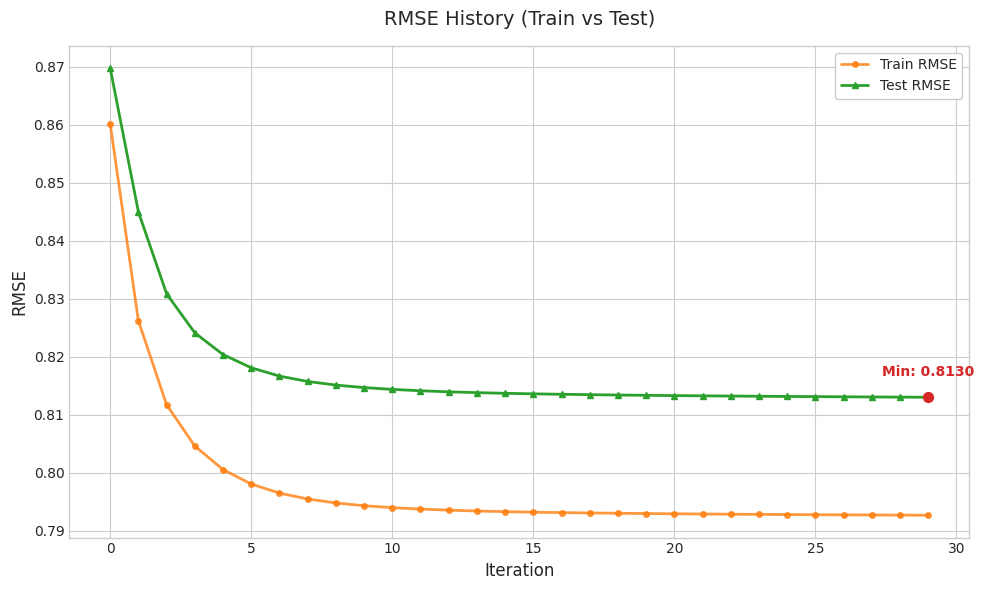

In [ ]:
plot_training_results(results32m)

In [ ]:
# @title
def plot_embedding_space(item_vectors, movies_df, data_csr,
                         num_movies_to_plot=2000,
                         highlight_genres=['Children', 'Horror', 'Documentary', 'Action', 'Sci-Fi']):
    """
    Visualizes the item embedding space and saves the output as an SVG file.
    - If K=2: Plots the latent factors directly (X vs Y).
    - If K>2: Uses t-SNE to project to 2D before plotting.

    Args:
        item_vectors: The (N_movies, K) numpy array of item embeddings.
        movies_df: Pandas DataFrame with 'movieId', 'title', 'genres'.
        data_csr: The data object with .get_movie_rating_counts() and .item_biases.
    """
    # 1. Filter for Top-Rated Movies
    # (We filter first to reduce noise and computation time)
    counts = data_csr.get_movie_rating_counts()
    top_indices = np.argsort(counts)[::-1][:num_movies_to_plot]
    vectors_top = item_vectors[top_indices]

    # 2. Determine Projection Method
    k_dim = item_vectors.shape[1]

    if k_dim == 2:
        print(f"Detected K=2. Plotting latent factors directly.")
        projections = vectors_top
        x_label, y_label = "K1", "K2"
        title_prefix = "Direct Projection"
    else:
        print(f"Detected K={k_dim}. Applying t-SNE to project to 2D...")
        # Init='pca' improves stability and preserves global structure better
        tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
        projections = tsne.fit_transform(vectors_top)
        x_label, y_label = "t-SNE Dimension 1", "t-SNE Dimension 2"
        title_prefix = "t-SNE Projection"

    # 3. Prepare Data for Plotting
    plot_data = []

    # Map back to Movie IDs and get Metadata
    for i, original_idx in enumerate(top_indices):
        mid = original_idx + 1 # Assuming 1-based movieId in dataframe
        row = movies_df[movies_df['movieId'] == mid]

        if not row.empty:
            title = row['title'].values[0]
            genres_str = row['genres'].values[0]

            # Assign Category (First match from highlight list)
            category = 'Other'
            for g in highlight_genres:
                if g in genres_str:
                    category = g
                    break

            plot_data.append({
                'x': projections[i, 0],
                'y': projections[i, 1],
                'Category': category,
                'Title': title
            })

    df_plot = pd.DataFrame(plot_data)

    # 4. Generate Plot
    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")

    # Create custom palette
    unique_cats = [g for g in highlight_genres if g in df_plot['Category'].unique()]
    palette = {g: c for g, c in zip(unique_cats, sns.color_palette("tab10", len(unique_cats)))}
    palette['Other'] = '#d3d3d3' # Light grey for background

    # Plot 'Other' first (background)
    sns.scatterplot(data=df_plot[df_plot['Category'] == 'Other'],
                    x='x', y='y', color=palette['Other'],
                    s=20, alpha=0.3, linewidth=0, label='Other')

    # Plot Highlights on top
    sns.scatterplot(data=df_plot[df_plot['Category'] != 'Other'],
                    x='x', y='y', hue='Category', palette=palette,
                    hue_order=unique_cats,
                    s=60, alpha=0.9, edgecolor='w', linewidth=0.5)

    plt.title(f"{title_prefix} of Item Embedding Space (Top {num_movies_to_plot} Movies)", fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Genre")

    # Add axes lines
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)

    plt.tight_layout()

    # --- CHANGE: Save as SVG ---
    plt.savefig('embedding_space.svg', format='svg', bbox_inches='tight')
    print("Plot saved as 'embedding_space.svg'")

    plt.show()

Detected K=20. Applying t-SNE to project to 2D...
Plot saved as 'embedding_space.svg'


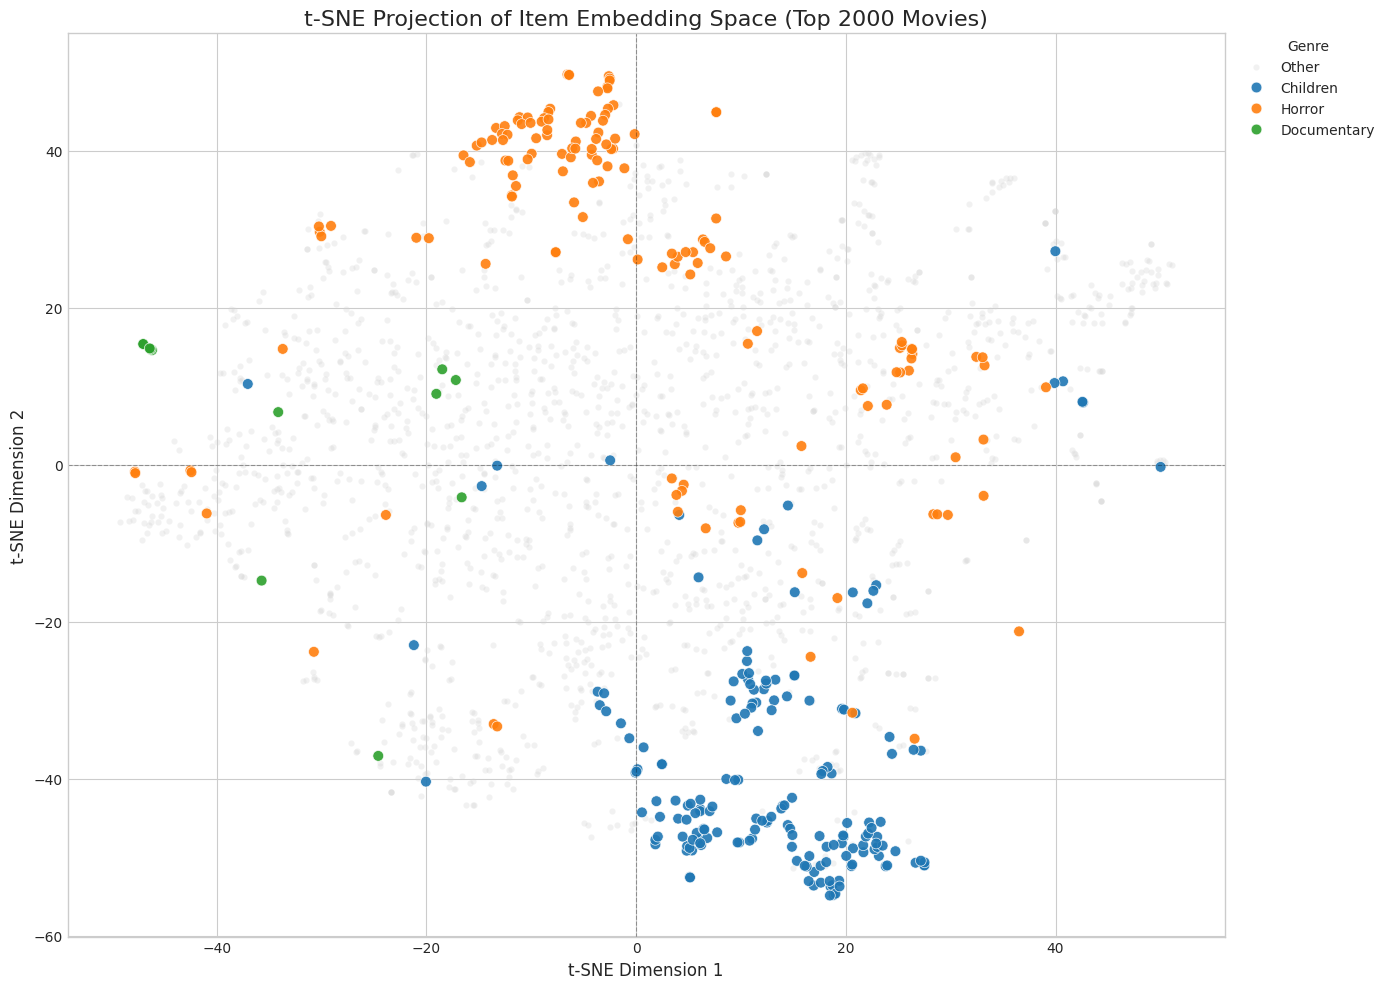

In [ ]:
plot_embedding_space(item_vectors32m, movies, data32m,
                         num_movies_to_plot=2000,
                         highlight_genres=['Children', 'Horror', 'Documentary'])